# **<center>LLM-BLENDER:**<center>
### <center>Ensembling Large Language Models with Pairwise Ranking and Generative Fusion<center>

**Paper link** : https://arxiv.org/abs/2306.02561

LLM-Blender is a novel framework designed to enhance the performance of large language models (LLMs) by combining the strengths of multiple models. It consists of two key modules: **PairRanker** and **GenFuser**. PairRanker utilizes a specialized method for pairwise comparison of candidate outputs, leveraging cross-attention encoders to determine the superior one based on input text. Results show that PairRanker correlates highly with ChatGPT-based ranking. GenFuser merges the top-ranked candidates to generate an improved output by capitalizing on their strengths and addressing weaknesses. The framework is evaluated using a benchmark dataset called MixInstruct, showcasing significant performance improvements over individual LLMs and baseline methods across various metrics.

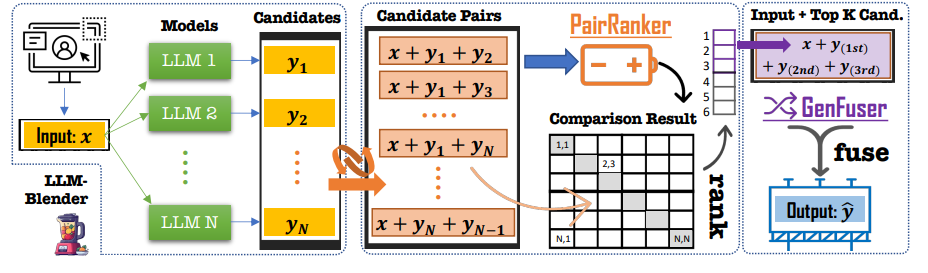

### **DataFlow :**

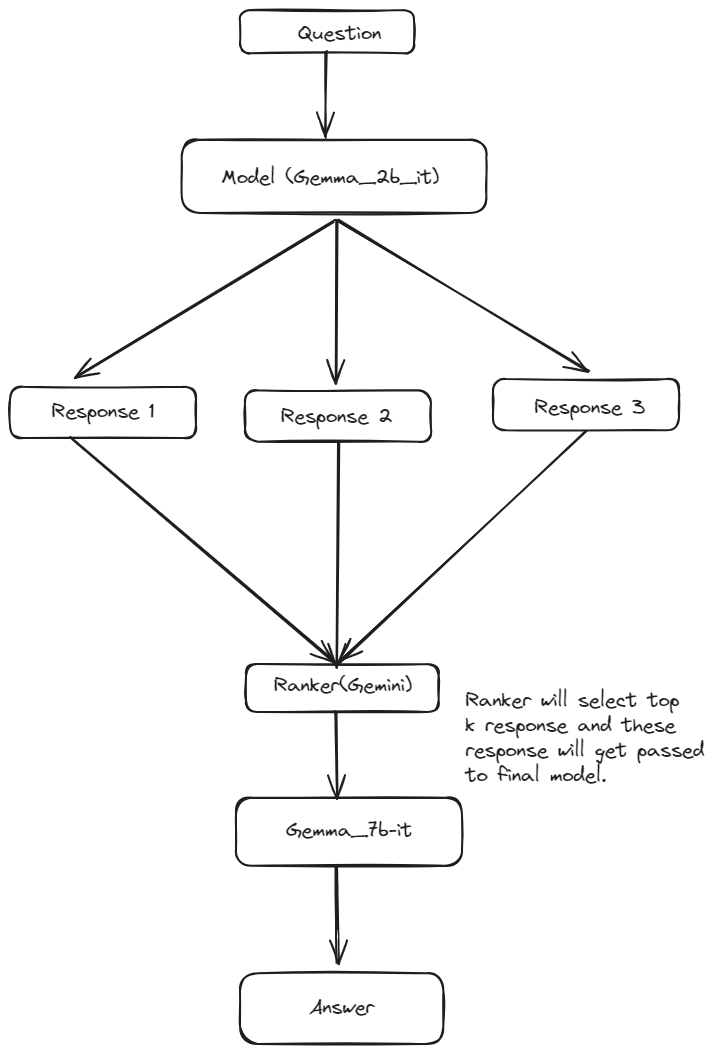

### **Code and Explanation :**

**Installing Necessary Modules**

In [1]:
!pip install git+https://github.com/huggingface/transformers -U
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-w52xs2_1
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-w52xs2_1
  Resolved https://github.com/huggingface/transformers to commit 2a002d073a337051bdc3fbdc95ff1bc0399ae2bb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.39.0.dev0-py3-none-any.whl size=8662148 sha256=01dd81eff412f31d9bcf73c7fb2faf6bfa136b93ababc857fd02c2ac5fb669ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-_r24t6ja/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.1
    Uninstalling transformers-4.38.1:
      Successfully uninstalled transformers-4.38.1
Looking in indexes: https://pypi.org/sim

🚚 **Imports**

In [2]:
import google.generativeai as genai
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,BitsAndBytesConfig
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("Gemini_api")
genai.configure(api_key=api_key)

**Models and Their Configurations**

I will be using 1 model and take 3 outputs and then try to ensemble them. But you can use this method to ensemble different model also.

In [4]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
safety_settings = [
    {
        "category": "HARM_CATEGORY_DANGEROUS",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_HARASSMENT",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_HATE_SPEECH",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
        "threshold": "BLOCK_NONE",
    },
]
tokenizer_fuser=AutoTokenizer.from_pretrained("/kaggle/input/gemma/transformers/7b-it/2")
tokenizer_generator = AutoTokenizer.from_pretrained("/kaggle/input/gemma/transformers/2b-it/2")
model= AutoModelForCausalLM.from_pretrained("/kaggle/input/gemma/transformers/2b-it/2",quantization_config=bnb_config,device_map={"":0})
model_fuser=AutoModelForCausalLM.from_pretrained("/kaggle/input/gemma/transformers/7b-it/2",quantization_config=bnb_config,device_map={"":0})
model_ranker = genai.GenerativeModel('gemini-pro')

OSError: /kaggle/input/gemma/transformers/7b-it/2 does not appear to have a file named config.json. Checkout 'https://huggingface.co//kaggle/input/gemma/transformers/7b-it/2/tree/None' for available files.

In [ ]:
question = "What is the best thing about Kaggle?"

### **Generating All Outputs :**
I will be using **Gemma-2b-it** for this part.

In [ ]:
input_ids = tokenizer_generator(question, return_tensors="pt")
outputs = model.generate(**input_ids,max_new_tokens=256,use_cache=False,do_sample=True,top_p=0.8)
outputs_1=tokenizer_generator.decode(outputs[0])
outputs = model.generate(**input_ids,max_new_tokens=256,do_sample=True,top_p=0.8,use_cache=False)
outputs_2=tokenizer_generator.decode(outputs[0])
outputs = model.generate(**input_ids,max_new_tokens=256,do_sample=True,top_p=0.8,use_cache=False)
outputs_3=tokenizer_generator.decode(outputs[0])
print("Model 1: ",outputs_1)
print("Model 2: ",outputs_2)
print("Model 3: ",outputs_3)

### **PairRanker :**

We compare each outputs and give a score on basis of this comparision using **Gemini**.

In [ ]:
def PairRanker(instruction,candidate1,candidate2):
    prompt = f'''
Instruction:
${instruction}
Input:
${input}
Candidate A:
${candidate1}
Candidate B:
${candidate2}
Given the instruction and input above, please compare the two candidates.
You only have 4 choices to output:
If you think A is better, please output: 1. A is better
If you think B is better, please output: 2. B is better
If you think both are good enough correctly give the answer, please output: 3. Same good
If you think both are bad and do not follow the instruction, please output: 4. Same bad
Do not output anything else except the 4 choices above.
Output your choice below:

'''
    response = model_ranker.generate_content(prompt,safety_settings=safety_settings)
    return response.text

# GenFuser

GenFuser takes top k model outputs as input and uses these inputs to give a better response. I will be using **Gemma-7b-it** for this process.

In [ ]:
def GenFuser(instruction,ranking,outputs,top_models=3):
    prompt =f''' 
    Instruction:{instruction} \n
    The outputs are in order of their quality and correctness. \n
    '''
    for i in range(top_models):
        prompt += f'''\n Output {i+1}: {outputs[ranking[i]]} \n'''
    prompt += f'''\n Fuse the outputs above to generate a better output. \n'''
    input_ids = tokenizer_fuser(question, return_tensors="pt")
    outputs = model_fuser.generate(**input_ids,max_new_tokens=512,use_cache=False,do_sample=True,top_p=0.8)
    outputs =tokenizer_fuser.decode(outputs[0])
    return outputs

# Ranking Strategy

The paper proposed 2 strategies :
-  MaxLogits
-  MaxWins

I used **MaxWins** strategy as in [paper](https://arxiv.org/abs/2306.02561) it was shown to perform better .

In [ ]:
def ranking_matrix(instruction,candidates,top_models=3):
    outputs = []
    for i in range(top_models):
        dummy = []
        for j in range(top_models):
            z=PairRanker(instruction,candidates[i],candidates[j])
            if z == "1. A is better":
                dummy.append(1)
            elif z == "2. B is better":
                dummy.append(-1)
            elif z == "3. Same good" or z == "4. Same bad":
                dummy.append(0)
        outputs.append(dummy)
    return outputs

In [ ]:
def rank_model(instruction,candidates,top_models=3):
    matrix = ranking_matrix(instruction,candidates,top_models)
    s=[]
    for i in range(top_models):
        k=0
        for j in range(top_models):
            k+=(matrix[i][j]-matrix[j][i])
        s.append(k)
    sort_index = [i for i, x in sorted(enumerate(s), key=lambda x: x[1])]
    return sort_index[::-1]

In [ ]:
rank=rank_model(question,[outputs_1,outputs_2,outputs_3])

# Final Inference

In [ ]:
GenFuser(question,rank,[outputs_1,outputs_2,outputs_3],2)